Read the input image

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pyexr import read
import pyshtools as pysh
from skimage.transform import resize
import torch

from svbrdf_uncertainty.util import sample_sphere

plt.rcParams["font.family"] = 'Linux Biolinum O'
plt.rcParams["mathtext.fontset"] = 'cm'

img = read('../scenes/envmaps/matpreview_envmap.exr')

data = resize(img, (512, 1024))

[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!


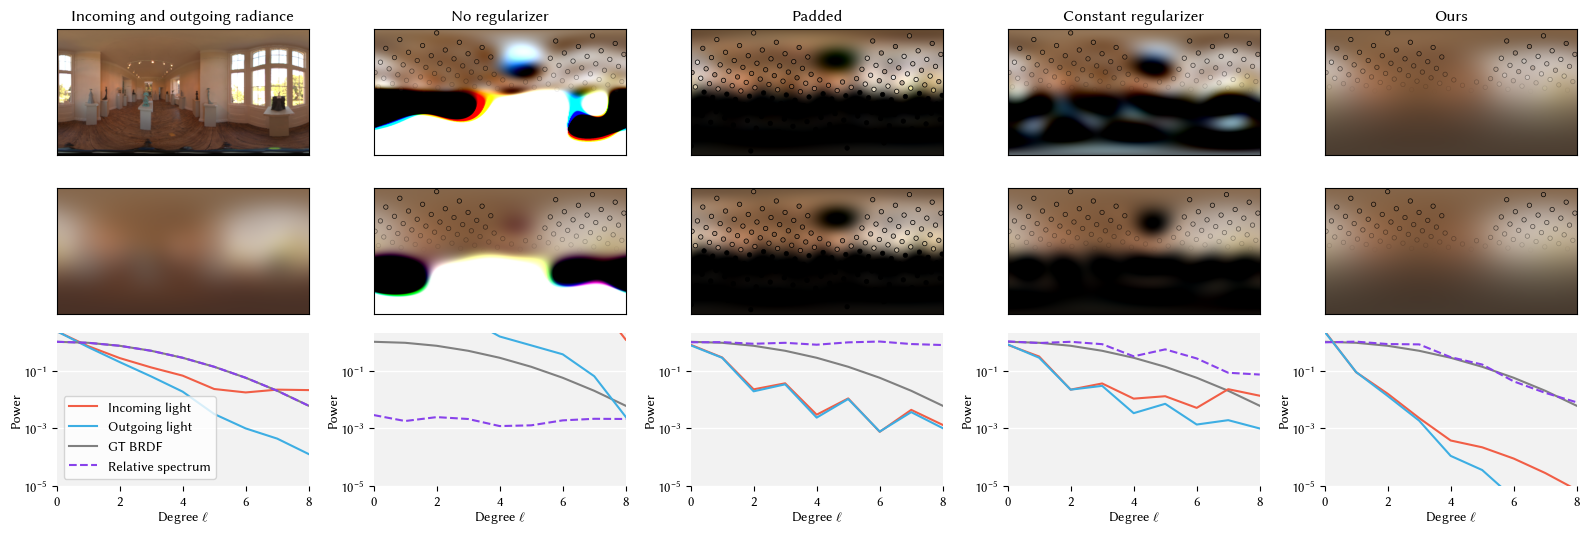

tensor(88)


In [3]:
from svbrdf_uncertainty.spherical_harmonics import lsq_spherical_harmonics, power_spectrum, expand_spherical_harmonics, gaussian_filter_spherical
from svbrdf_uncertainty.util import sample_envmap

def microfacet_coeffs(coeffs, alpha=0.01):
    coeffs_filtered = coeffs.copy()
    brdf = np.exp(-(alpha * np.arange(coeffs.shape[1])) ** 2)
    coeffs_filtered = coeffs * brdf[None, :, None]
    return coeffs_filtered

def plot_spherical_image(data, ax, vmin=0, vmax=2, cmap='viridis'):
    pcm = ax.imshow(data, extent=(-np.pi, np.pi, np.pi, 0), cmap=cmap, vmin=vmin, vmax=vmax)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return pcm

def filter_and_plot(data, n_samples=512, alpha=0.01, lmax=10, regularizer=0.001, sampling_method='fibonacci', hemisphere=True):
    data_original = (data ** (1 / 2.2)).clip(0, 1)

    coeffs = pysh.expand.SHExpandDH(data.mean(axis=-1), sampling=2, norm=4)
    coeffs_filtered = microfacet_coeffs(coeffs, alpha)

    data = torch.from_numpy(data_original)
    data = gaussian_filter_spherical(data, 1 / np.sqrt(n_samples))
    data_filtered = gaussian_filter_spherical(data, alpha)

    # Take samples of filtered function and input function
    normal, t_basis, s_basis = torch.Tensor([[[0, 1, 0]]]), torch.Tensor([[[1, 0, 0]]]), torch.Tensor([[[0, 0, -1]]])
    radiance_samples, theta_full, phi_full = sample_envmap(n_samples, torch.cat([data, data_filtered], dim=-1), normal, t_basis, s_basis, None, method='fibonacci')
    mask = theta_full < torch.pi / 2
    mask_hole = ((torch.square(phi_full - torch.pi / 6) + torch.square(theta_full - torch.pi / 6)) > torch.pi/6)
    mask = mask_hole * mask
    in_light_samples = radiance_samples[..., :3][mask].squeeze()
    out_light_samples = radiance_samples[..., 3:][mask].squeeze()
    theta, phi = theta_full[mask].squeeze(), phi_full[mask].squeeze()

    # Compute maximum spherical harmonics basis
    lmax = min(int(np.sqrt(in_light_samples.shape[0]) - 1), 40) if lmax <= 0 else lmax


    # Plot samples and filtered function
    fig, ax = plt.subplot_mosaic([['in',  'in_no', 'in_padded', 'in_const', 'in_ours'],
                                  ['out', 'out_no', 'out_padded', 'out_const', 'out_ours'],
                                  ['spectrum', 'spectrum_no', 'spectrum_padded', 'spectrum_const', 'spectrum_ours']],
                                figsize=(16, 5.5))
    red = '#F15E46'
    blue = '#3DAEE3'
    purple = '#8842eb'
    grey = '#BBBBBB'

    brdf = np.exp(-(alpha * np.arange(lmax + 1)) ** 2) ** 2

    plot_spherical_image(data_original, ax['in'])
    plot_spherical_image(data_filtered, ax['out'])
    ax['in'].set_title('Incoming and outgoing radiance')

    in_light_spectrum_grid = pysh.spectralanalysis.spectrum(coeffs, unit='per_lm')
    out_light_spectrum_grid = pysh.spectralanalysis.spectrum(coeffs_filtered, unit='per_lm')
    ax['spectrum'].plot(in_light_spectrum_grid, label='Incoming light', c=red)
    ax['spectrum'].plot(out_light_spectrum_grid, label='Outgoing light', c=blue)
    rho_estimated_grid = out_light_spectrum_grid / in_light_spectrum_grid
    ax['spectrum'].plot(brdf, label='GT BRDF', c='gray')
    ax['spectrum'].plot(rho_estimated_grid, label='Relative spectrum', c=purple, linestyle='dashed')

    # Fit spherical harmonics to samples
    weight = torch.cos(theta)

    # NO REGULARIZER
    # --------------
    in_light_coeffs_no = lsq_spherical_harmonics(in_light_samples, theta, phi, lmax=lmax, weight=weight, regularizer=0, regularizer_func=torch.exp)
    out_light_coeffs_no = lsq_spherical_harmonics(out_light_samples, theta, phi, lmax=lmax, weight=weight, regularizer=0, regularizer_func=torch.exp)

    # Show reconstructed function from samples
    in_light_reconstructed_no = expand_spherical_harmonics(in_light_coeffs_no, res_theta=512, res_phi=256).clamp(0, 1)
    out_light_reconstructed_no = expand_spherical_harmonics(out_light_coeffs_no, res_theta=512, res_phi=256).clamp(0, 1)
    plot_spherical_image(in_light_reconstructed_no, ax['in_no'])
    ax['in_no'].set_title('No regularizer')
    ax['in_no'].scatter(phi, theta, c=in_light_samples, s=10, linewidths=0.5, edgecolors='black', alpha=weight)
    plot_spherical_image(out_light_reconstructed_no, ax['out_no'])
    ax['out_no'].scatter(phi, theta, c=out_light_samples, s=10, linewidths=0.5, edgecolors='black', alpha=weight)

    in_light_spectrum_no = power_spectrum(in_light_coeffs_no.mean(dim=-1, keepdims=True), unit='per_lm').flatten()
    out_light_spectrum_no = power_spectrum(out_light_coeffs_no.mean(dim=-1, keepdims=True), unit='per_lm').flatten()
    ax['spectrum_no'].plot(brdf, label='Filter', c='gray')
    ax['spectrum_no'].plot(in_light_spectrum_no, label='Incoming light', c=red)
    ax['spectrum_no'].plot(out_light_spectrum_no, label='Outgoing light', c=blue)
    rho_estimated_no = out_light_spectrum_no / in_light_spectrum_no
    ax['spectrum_no'].plot(rho_estimated_no, label='Estimated BRDF', c=purple, linestyle='dashed')

    # PADDED
    # --------------
    in_light_samples_padded = radiance_samples[..., :3][mask_hole].squeeze()
    out_light_samples_padded = radiance_samples[..., 3:][mask_hole].squeeze()
    theta_padded, phi_padded = theta_full[mask_hole].squeeze(), phi_full[mask_hole].squeeze()
    in_light_samples_padded[theta_padded > np.pi / 2] = 0
    out_light_samples_padded[theta_padded > np.pi / 2] = 0
    in_light_coeffs_padded = lsq_spherical_harmonics(in_light_samples_padded, theta_padded, phi_padded, lmax=lmax, regularizer=0, regularizer_func=torch.exp)
    out_light_coeffs_padded = lsq_spherical_harmonics(out_light_samples_padded, theta_padded, phi_padded, lmax=lmax, regularizer=0, regularizer_func=torch.exp)

    # Show reconstructed function from samples
    in_light_reconstructed_padded = expand_spherical_harmonics(in_light_coeffs_padded, res_theta=512, res_phi=256).clamp(0, 1)
    out_light_reconstructed_padded = expand_spherical_harmonics(out_light_coeffs_padded, res_theta=512, res_phi=256).clamp(0, 1)
    plot_spherical_image(in_light_reconstructed_padded, ax['in_padded'])
    ax['in_padded'].set_title('Padded')
    ax['in_padded'].scatter(phi_padded, theta_padded, c=in_light_samples_padded, s=10, linewidths=0.5, edgecolors='black')
    plot_spherical_image(out_light_reconstructed_padded, ax['out_padded'])
    ax['out_padded'].scatter(phi_padded, theta_padded, c=out_light_samples_padded, s=10, linewidths=0.5, edgecolors='black')

    in_light_spectrum_padded = power_spectrum(in_light_coeffs_padded.mean(dim=-1, keepdims=True), unit='per_lm').flatten()
    out_light_spectrum_padded = power_spectrum(out_light_coeffs_padded.mean(dim=-1, keepdims=True), unit='per_lm').flatten()
    ax['spectrum_padded'].plot(brdf, label='Filter', c='gray')
    ax['spectrum_padded'].plot(in_light_spectrum_padded, label='Incoming light', c=red)
    ax['spectrum_padded'].plot(out_light_spectrum_padded, label='Outgoing light', c=blue)
    rho_estimated_padded = out_light_spectrum_padded / in_light_spectrum_padded
    ax['spectrum_padded'].plot(rho_estimated_padded, label='Estimated BRDF', c=purple, linestyle='dashed')

    # CONSTANT REGULARIZER
    # --------------------
    in_light_coeffs_const = lsq_spherical_harmonics(in_light_samples, theta, phi, lmax=lmax, weight=weight, regularizer=regularizer, regularizer_func=torch.ones_like)
    out_light_coeffs_const = lsq_spherical_harmonics(out_light_samples, theta, phi, lmax=lmax, weight=weight, regularizer=regularizer, regularizer_func=torch.ones_like)

    # Show reconstructed function from samples
    in_light_reconstructed_const = expand_spherical_harmonics(in_light_coeffs_const, res_theta=512, res_phi=256).clamp(0, 1)
    out_light_reconstructed_const = expand_spherical_harmonics(out_light_coeffs_const, res_theta=512, res_phi=256).clamp(0, 1)
    plot_spherical_image(in_light_reconstructed_const, ax['in_const'])
    ax['in_const'].set_title('Constant regularizer')
    ax['in_const'].scatter(phi, theta, c=in_light_samples, s=10, linewidths=0.5, edgecolors='black', alpha=weight)
    plot_spherical_image(out_light_reconstructed_const, ax['out_const'])
    ax['out_const'].scatter(phi, theta, c=out_light_samples, s=10, linewidths=0.5, edgecolors='black', alpha=weight)

    in_light_spectrum_const = power_spectrum(in_light_coeffs_const.mean(dim=-1, keepdims=True), unit='per_lm').flatten()
    out_light_spectrum_const = power_spectrum(out_light_coeffs_const.mean(dim=-1, keepdims=True), unit='per_lm').flatten()
    ax['spectrum_const'].plot(brdf, label='Filter', c='gray')
    ax['spectrum_const'].plot(in_light_spectrum_const, label='Incoming light', c=red)
    ax['spectrum_const'].plot(out_light_spectrum_const, label='Outgoing light', c=blue)
    rho_estimated_const = out_light_spectrum_const / in_light_spectrum_const
    ax['spectrum_const'].plot(rho_estimated_const, label='Estimated BRDF', c=purple, linestyle='dashed')

    # OUR APPROACH
    # ------------
    in_light_coeffs = lsq_spherical_harmonics(in_light_samples, theta, phi, lmax=lmax, weight=weight, regularizer=regularizer, regularizer_func=torch.exp)
    out_light_coeffs = lsq_spherical_harmonics(out_light_samples, theta, phi, lmax=lmax, weight=weight, regularizer=regularizer, regularizer_func=torch.exp)

    # Show reconstructed function from samples
    in_light_reconstructed = expand_spherical_harmonics(in_light_coeffs, res_theta=512, res_phi=256).clamp(0, 1)
    out_light_reconstructed = expand_spherical_harmonics(out_light_coeffs, res_theta=512, res_phi=256).clamp(0, 1)
    plot_spherical_image(in_light_reconstructed, ax['in_ours'])
    ax['in_ours'].set_title('Ours')
    ax['in_ours'].scatter(phi, theta, c=in_light_samples, s=10, linewidths=0.5, edgecolors='black', alpha=weight)
    plot_spherical_image(out_light_reconstructed, ax['out_ours'])
    ax['out_ours'].scatter(phi, theta, c=out_light_samples, s=10, linewidths=0.5, edgecolors='black', alpha=weight)

    in_light_spectrum = power_spectrum(in_light_coeffs.mean(dim=-1, keepdims=True), unit='per_lm').flatten()
    out_light_spectrum = power_spectrum(out_light_coeffs.mean(dim=-1, keepdims=True), unit='per_lm').flatten()
    ax['spectrum_ours'].plot(brdf, label='Filter', c='gray')
    ax['spectrum_ours'].plot(in_light_spectrum, label='Incoming light', c=red)
    ax['spectrum_ours'].plot(out_light_spectrum, label='Outgoing light', c=blue)
    rho_estimated = out_light_spectrum / in_light_spectrum
    ax['spectrum_ours'].plot(rho_estimated, label='Estimated BRDF', c=purple, linestyle='dashed')

    # Settings for spectrum plot
    # --------------------------
    for name in ['spectrum', 'spectrum_no', 'spectrum_padded', 'spectrum_const', 'spectrum_ours']:
        ax[name].set_yscale('log')
        ax[name].set_xlim(0, lmax)
        ax[name].set_ylim(1e-5, 2)
        ax[name].set_ylabel('Power', labelpad=0)
        ax[name].set_xlabel(r'Degree $\ell$', labelpad=0)
        ax[name].grid(which='major', axis='both', linestyle='-', color='grey', linewidth=0.5)
        ax[name].set_facecolor((0.95, 0.95, 0.95))
        ax[name].spines['top'].set_visible(False)
        ax[name].spines['right'].set_visible(False)
        ax[name].spines['bottom'].set_visible(False)
        ax[name].spines['left'].set_visible(False)
        ax[name].grid(visible=True, axis='y', c='white', linewidth=1)
        ax[name].grid(visible=False, axis='x')

    ax['spectrum'].legend()
    plt.tight_layout()
    plt.show()
    print(mask.sum())

# Create synthetic data
filter_and_plot(data=data, n_samples=200, alpha=0.2, lmax=8, regularizer=1e-2, sampling_method='fibonacci')